### RFM Analysis
RFM : Recency(최근 구매), Frequency(자주 구매), Monetary(얼마나 구매)

즉, 사용자의 유형을 3가지 기준에 따라 segmentation하여 각 segment의 유형을 파악하는 분석 기법이다.

In [187]:
import pymysql
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import csv
import os
import time
from dotenv import load_dotenv
load_dotenv()
MYSQL_ROOT_PW = os.environ.get("MYSQL_ROOT_PW")
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [142]:
con = pymysql.connect(host="localhost", db="ecommerce", user="root", password=MYSQL_ROOT_PW)
cur = con.cursor()

In [143]:
column_dict = {}

cur.execute("SHOW tables;")
for table in [x[0] for x in cur.fetchall()]:
    query = f"SHOW columns from {table};"
    cur.execute(query)
    table_cols = [x[0] for x in cur.fetchall()]
    column_dict[table] = table_cols

In [144]:
# SELECT query의 결과를 dataframe 형태로 return하여 보여주는 함수
# query : SELECT ~ FROM ~ 문

def fetchresult_to_df(query):
    cur.execute(query)
    result = cur.fetchall()
    return pd.DataFrame(result)

In [145]:
# customer table
# 고객의 ID, 성별, 거주지, 가입 이후 기간 (개월)

try:
    query = """
    SELECT *
    FROM customer;
    """
    df = fetchresult_to_df(query)
    df.columns = column_dict["customer"]
    display(df.head(3))
except:
    print("SQL Server Connection Error!")

,customer_id,gender,city,duration
0,USER_0000,여,New York,31
1,USER_0001,남,New York,20
2,USER_0002,남,California,39


In [146]:
# onlinesales table
# 고객의 ID, 거래 ID, 거래 일시, 상품 ID 등 ...

try:
    query = """
    SELECT *
    FROM onlinesales;
    """
    df = fetchresult_to_df(query)
    df.columns = column_dict["onlinesales"]
    display(df.head(3))
except:
    print("SQL Server Connection Error!")

,customer_id,transaction_id,transaction_date,product_id,category,amount,average_price,shipping_fee,coupon_status
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used


#### 1. Recency : 최근 구매

고객들의 최근 구매일자 분포를 확인하고, 3개의 그룹으로 나누어 각 고객의 특성을 분석한다.

3개의 그룹으로 나눈 이유는 ... 내맘임

In [153]:
# 각 customer_id별로 가장 최근의 거래 일자를 확인
# 2019-01-01 ~ 2019-12-31 범위의 거래가 포착됨 -> 데이터셋은 2019년도의 거래 데이터만을 대상으로 하고 있음을 유추 가능

try:
    query = """
    SELECT customer_id, MAX(transaction_date) recent_purchase_date
    FROM onlinesales
    GROUP BY 1
    ORDER BY 2 DESC;
    """
    df = fetchresult_to_df(query)
    df.columns = ["customer_id", "recent_purchase_date"]
    display(df)
except:
    print("SQL Server Connection Error!")

,customer_id,recent_purchase_date
0,USER_0563,2019-12-31
1,USER_0513,2019-12-31
2,USER_0167,2019-12-31
3,USER_0845,2019-12-31
4,USER_0504,2019-12-31
...,...,...
1463,USER_0922,2019-01-02
1464,USER_1421,2019-01-02
1465,USER_1249,2019-01-02
1466,USER_0954,2019-01-02


In [161]:
try:
    query = """
    WITH RECENT_PURCHASE AS (
    SELECT customer_id, MAX(transaction_date) recent_purchase_date
    FROM onlinesales
    GROUP BY 1
    ORDER BY 2 DESC)

    SELECT RECENT_PURCHASE_DATE, COUNT(*)
    FROM RECENT_PURCHASE
    GROUP BY 1
    ORDER BY 1
    """
    recent_df = fetchresult_to_df(query)
    recent_df.columns = ["recent_purchase_date", "count"]
    display(recent_df.head(3))
except:
    print("SQL Server Connection Error!")

,recent_purchase_date,count
0,2019-01-01,1
1,2019-01-02,4
2,2019-01-03,5


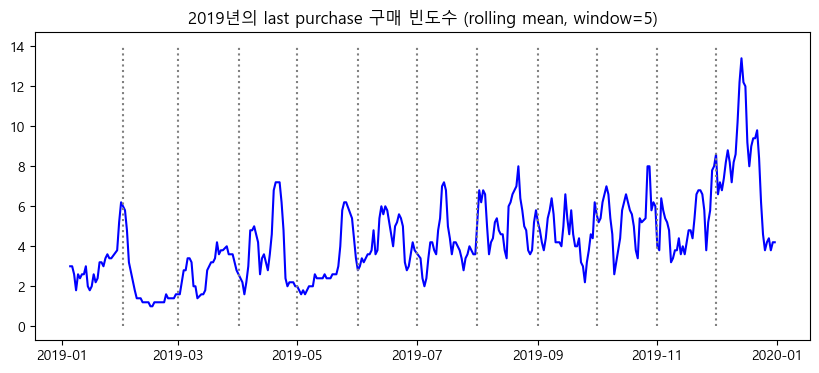

In [246]:
# 2019.01.01 ~ 2019.12.31 발생한 last purchase의 연간 변동 흐름을 시각화
# 2019년 말의 급격한 상승을 제외하고는 1 ~ 11월 내내 last purchase 건수가 진동하는 모습

plt.figure(figsize=(10, 4))
plt.title("2019년의 last purchase 구매 빈도수 (rolling mean, window=5)")
plt.plot(recent_df["recent_purchase_date"], recent_df["count"].rolling(window=5).mean(), color="blue")
plt.vlines(x=[datetime.datetime(2019, x, 1) for x in range(2, 13)], ymin=0, ymax = 14, color='gray', linestyle='dotted')
plt.show()

In [268]:
# customer table에 r_segment 컬럼을 추가

try:
    query = """
    ALTER TABLE customer ADD COLUMN r_segment INTEGER NULL;
    """
    cur.execute(query)
    con.commit()
except:
    print("SQL Server Connection Error!")

In [269]:
# 추가된 customer.r_segment 컬럼에 onlinesales 테이블로부터 집계된 r_segment 번호를 업데이트
# r_segment의 번호가 클수록(1->3) 최근에 구매한 고객

try:
    query = """
    WITH RECENT_PURCHASE AS (
        SELECT customer_id, MAX(transaction_date) recent_purchase_date
        FROM onlinesales
        GROUP BY 1),

    R_SEGMENT_TBL AS (
    SELECT *, NTILE(3) OVER(ORDER BY recent_purchase_date ASC) r_segment
    FROM RECENT_PURCHASE)

    UPDATE customer
    JOIN R_SEGMENT_TBL on R_SEGMENT_TBL.customer_id = customer.customer_id
    SET customer.r_segment = R_SEGMENT_TBL.r_segment
    """

    cur.execute(query)
    con.commit()

except:
    print("SQL Server Connection Error!")

In [271]:
# r_segment 데이터가 잘 삽입되었는지 확인!

try:
    query = """
    select *
    from customer
    limit 5;
    """
    df = fetchresult_to_df(query)
    df.columns = ["customer_id", "gender", "city", "duration", "r_segment"]
    display(df.head(3))
except:
    print("SQL Server Connection Error!")

,customer_id,gender,city,duration,r_segment
0,USER_0000,여,New York,31,2
1,USER_0001,남,New York,20,3
2,USER_0002,남,California,39,3


#### 2. Frequency : 자주 구매

고객들의 구매 횟수 분포를 확인하고, 4개의 그룹으로 나누어 각 고객의 특성을 분석한다.

In [326]:
# 이커머스에서 단 1회만 구매한 고객이 매우 많을 것으로 추측된다.

try:
    query = """
    SELECT customer_id, count(transaction_id) count
    FROM onlinesales
    GROUP BY 1
    order by 2;
    """
    frequency_df = fetchresult_to_df(query)
    frequency_df.columns = ["customer_id", "count"]
    display(frequency_df.head())
except:
    print("SQL Server Connection Error!")

,customer_id,count
0,USER_0345,1
1,USER_0344,1
2,USER_1384,1
3,USER_0677,1
4,USER_1133,1


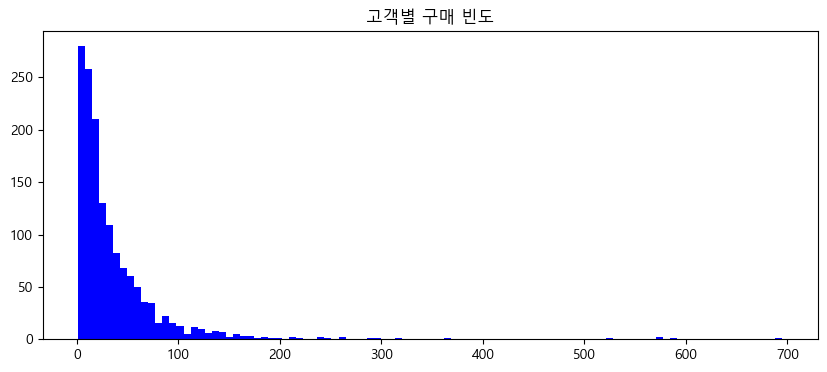

In [327]:
# 오른쪽으로 꼬리가 매우 긴 분포를 가지고 있음
# idea => quantile을 기준으로 고객의 f-segment를 분류

plt.figure(figsize=(10, 4))
plt.title("고객별 구매 빈도")
plt.hist(frequency_df["count"], bins=100, color="blue")
plt.show()

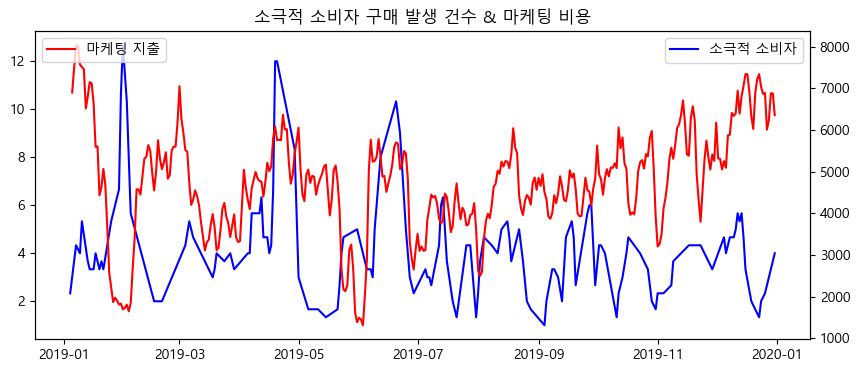

In [448]:
# 5회 이하로 구매한 소극적 소비자의 거래 발생과 마케팅 비용관의 관계를 살펴보는 시각화
# 상반기에는 마케팅 비용이 증가함에 따라 소극적 소비자의 구매가 증가하지만, 하반기에는 그렇지 않은 모습
# => 이미 유입될만한 사람들은 상반기의 마케팅으로 유입되었고, 
# 하반기에는 새롭게 유입되는 소비자가 없거나, 상반기에 유입되어 적극적 구매자로 변하였을 확률

try:
    query = """
    WITH PURCHASE_LOG as (
    SELECT customer_id, transaction_date
    FROM onlinesales),

    PURCHASE_LITTLE as (
    SELECT customer_id, count(transaction_id) count
    FROM onlinesales
    GROUP BY 1
    HAVING count(transaction_id) < 6)

    SELECT customer_id, transaction_date
    FROM PURCHASE_LOG
    where customer_id in (select customer_id from PURCHASE_LITTLE)
    """
    little_df = fetchresult_to_df(query)
    little_df.columns = ["customer_id", "purchase_date"]
    little_df = little_df["purchase_date"].value_counts().sort_index()

    query = """
    SELECT marketing_date, sum(offline_expense) + sum(online_expense)
    FROM marketing
    group by 1;
    """
    marketing_df = fetchresult_to_df(query)
    marketing_df.columns = ["marketing_date", "all_marketing_expense"]
except:
    print("SQL Server Connection Error!")


fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.set_title("소극적 소비자 구매 발생 건수 & 마케팅 비용")
ax1.plot(little_df.index, pd.Series(little_df.values).rolling(window=3).mean(), color="blue", label="소극적 소비자")
ax2 = ax1.twinx()
ax2.plot(marketing_df["marketing_date"], marketing_df["all_marketing_expense"].rolling(window=5, win_type="exponential").mean(), 
            color="red", label="마케팅 지출")
ax1.legend(loc=0)
ax2.legend(loc=2)
plt.show()

In [449]:
# customer table에 f_segment 컬럼을 추가

try:
    query = """
    ALTER TABLE customer ADD COLUMN f_segment INTEGER NULL;
    """
    cur.execute(query)
    con.commit()
except:
    print("SQL Server Connection Error!")

In [ ]:
# f_segment의 번호가 클수록(1->4) 자주 구매한 고객
# (1) f_segment 1 : 10개 미만 구매
# (2) f_segment 2 : 30개 미만 구매
# (3) f_segment 3 : 50개 미만 구매
# (4) f_segment 4 : 50개 이상 구매

try:
    query = """
    WITH FREQUENCY AS (
    SELECT customer_id, count(transaction_id) count
    FROM onlinesales
    GROUP BY 1
    ),

    F_SEGMENT_TBL AS
    (
        SELECT
            customer_id,
            CASE
                WHEN count < 10
                THEN 1
                WHEN count < 30
                THEN 2
                WHEN count < 50
                THEN 3
                ELSE 4
            END f_segment
        FROM FREQUENCY
    )

    UPDATE customer
    JOIN F_SEGMENT_TBL on F_SEGMENT_TBL.customer_id = customer.customer_id
    SET customer.f_segment = F_SEGMENT_TBL.f_segment
    """
    cur.execute(query)
    con.commit()
except:
    print("SQL Server Connection Error!")


#### 3. Monetary : 얼마나 구매

고객들의 구매 가격 분포를 확인하고, 3개의 그룹으로 나누어 각 고객의 특성을 분석한다.

In [460]:
try:
    query = """
    SELECT customer_id, sum(amount * average_price)
    FROM onlinesales
    GROUP BY 1
    ORDER BY 2 DESC;
    """
    money_df = fetchresult_to_df(query)
    money_df.columns = ["customer_id", "money"]
    display(money_df.head())
except:
    print("SQL Server Connection Error!")

,customer_id,money
0,USER_0736,75937.550221
1,USER_0118,74601.359679
2,USER_0563,57137.790113
3,USER_0643,48980.380065
4,USER_1355,46205.769913


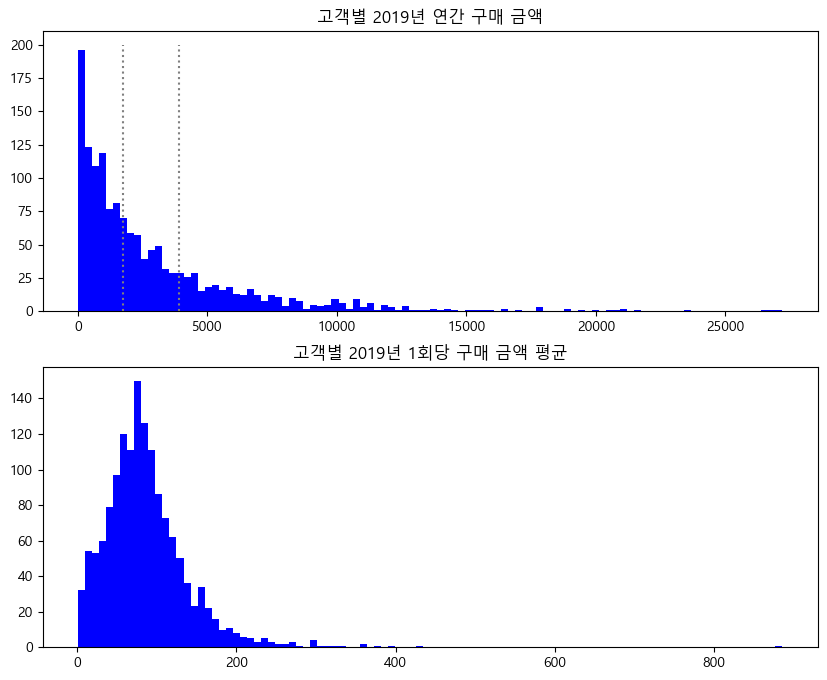

In [ ]:
# 오른쪽으로 꼬리가 매우 긴 분포를 가지고 있음
# idea => quantile(0.5), quantile(0.75)를 기준으로 m-segment를 분류

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 8))
ax[0].hist(money_df.loc[money_df["money"] < 30000, "money"], bins=100, color="blue")
ax[0].vlines(x=[money_df["money"].quantile(x) for x in [0.25*y for y in range(2, 4)]], 
    ymin=0, ymax=200, color="gray", linestyle='dotted')
ax[0].set_title("고객별 2019년 연간 구매 금액")

temp = frequency_df.merge(money_df, on="customer_id", how="inner")
temp["회당 구매가격"] = temp["money"] / temp["count"]
ax[1].hist(temp["회당 구매가격"], bins=100, color="blue")
ax[1].set_title("고객별 2019년 1회당 구매 금액 평균")

plt.show()

In [508]:
# customer table에 m_segment 컬럼을 추가

try:
    query = """
    ALTER TABLE customer ADD COLUMN m_segment INTEGER NULL;
    """
    cur.execute(query)
    con.commit()
except:
    print("SQL Server Connection Error!")

In [509]:
# m_segment의 번호가 클수록(1->3) 많은 금액을 구매한 고객

try:
    query = """
    WITH MONETARY AS (
        SELECT customer_id, sum(amount * average_price) money
        FROM onlinesales
        GROUP BY 1
        ORDER BY 2 DESC
    ),

    M_SEGMENT_TBL AS (
        SELECT customer_id, money,
            CASE
                WHEN ntile(4) OVER (ORDER BY money) <= 2 THEN 1
                WHEN ntile(4) OVER (ORDER BY money) <= 3 THEN 2
                ELSE 3
            END m_segment
        FROM MONETARY
    )

    UPDATE customer
    JOIN M_SEGMENT_TBL on M_SEGMENT_TBL.customer_id = customer.customer_id
    SET customer.m_segment = M_SEGMENT_TBL.m_segment
    """

    cur.execute(query)
    con.commit()
    
except:
    print("SQL Server Connection Error!")

#### 4. 고객 Segment 확인

In [523]:
try:
    query = """
    SELECT customer_id,
        MAX(transaction_date) recency,
        COUNT(transaction_id) frequency,
        SUM(amount * average_price) monetary,
        r_segment, f_segment, m_segment
    FROM customer JOIN onlinesales using (customer_id)
    GROUP BY 1
    ORDER BY 2, 3, 4
    """
    rfm_df = fetchresult_to_df(query)
    rfm_df.columns = ["customer_id", "recency", "frequency", "monetary", "r_segment", "f_segment", "m_segment"]
    rfm_df["RFM_segment"] = rfm_df["r_segment"].astype(str) + rfm_df["f_segment"].astype(str) + rfm_df["m_segment"].astype(str)
    display(rfm_df.head())
except:
    print("SQL Server Connection Error!")

,customer_id,recency,frequency,monetary,r_segment,f_segment,m_segment,RFM_segment
0,USER_0345,2019-01-01,1,1.240000,1,1,1,111
1,USER_1249,2019-01-02,7,544.020022,1,1,1,111
2,USER_0922,2019-01-02,12,842.389999,1,2,1,121
3,USER_1421,2019-01-02,13,1830.270061,1,2,2,122
4,USER_0954,2019-01-02,14,1965.430040,1,2,2,122


In [705]:
rfm_segment = [str(x) + str(y) + str(z) for x in range(1,4) for y in range(1,5) for z in range(1,4)]
rfm_colordict = {}

for x in range(1,4):
    for y in range(1,5):
        for z in range(1,4):
            rfm_colordict[str(x)+str(y)+str(z)] = (1/3*(x-1), 1/4*(y-1), 1/3*(z-1))

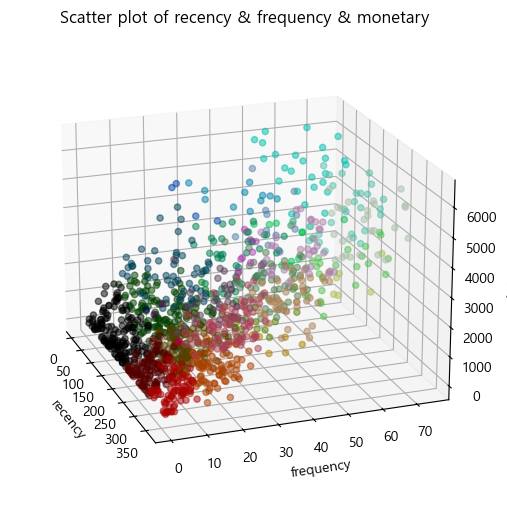

In [706]:
# r_segment & f_segment & m_segment 간의 관계
# 각 point의 색은 RFM segment(e.g. 111, 143) 을 나타내며, 유사한 특성의 segment는 비슷한 색을 가지도록 시각화되었다.
# => recency, frequency, monetary는 3차원상의 hyperplane 형태로 나타난다. 즉, 선형적인 관계가 관찰된다.

rfm_df["recency_365"] = rfm_df["recency"].apply(lambda x : time.strptime(str(x), "%Y-%m-%d").tm_yday)

def detect_outliers(df,columns):
    q1=df[columns].quantile(0.25)
    q3=df[columns].quantile(0.75)
    iqr=q3-q1
    
    boundary=1.5*iqr
    
    index1=df[df[columns] > q3+boundary].index
    index2=df[df[columns] < q1-boundary].index 
    
    df[columns]=df[columns].drop(index1)
    df[columns]=df[columns].drop(index2)
    
    return df

rfm_df = detect_outliers(rfm_df,'recency_365')
rfm_df = detect_outliers(rfm_df,'frequency')
rfm_df = detect_outliers(rfm_df,'monetary')

fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot(projection='3d')
color = rfm_df["RFM_segment"].map(rfm_colordict)
ax.scatter(rfm_df["recency_365"], rfm_df["frequency"], rfm_df["monetary"], 
            alpha=.5, c=color)
ax.set_title("Scatter plot of recency & frequency & monetary")
ax.view_init(elev=20, azim=-20, roll=0)
ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetary')
plt.tight_layout()
plt.show()

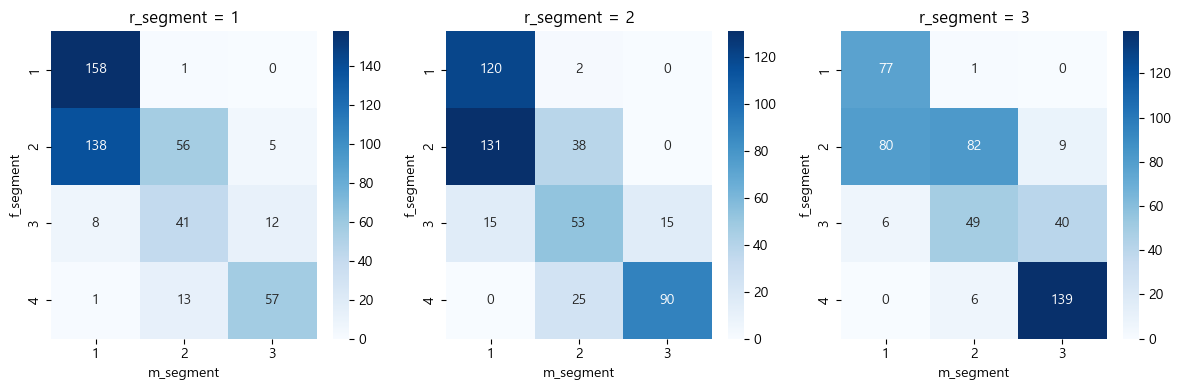

In [707]:
# r_segment 별 f_segment, m_segment 분포를 살펴본다.
# r_segment1, r_segment2 모두 유사한 유형의 분포를 가진다. 
#   -> 최근 구매 이력이 없는 소비자는, 당연하게도 구매 빈도가 적으며 구매 금액 역시 작다.
#   -> r_segment1의 f_segment4 + m_segment3 그룹, r_segment2의 f_segment4 + m_segment3 그룹은 이탈한 VIP 고객
# r_segment3은 r_segment1, r_segment2와 다르게 f_segment4 + m_segment3 의 비율이 가장 높다.
#   -> r_segment3 + f_segment4 + m_segment3 : 충성도가 높은 VIP 고객
#   -> r_segment3 + f_segment1~2 + m_segment1~2 : 신규 유입 고객
#   -> r_segment3 + f_segment2~3 + m_segment2~3 : 잠재 VIP 고객

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

for r in range(1, 4):
    r_segment = rfm_df.loc[rfm_df["r_segment"] == r]
    sns.heatmap(pd.crosstab(index=r_segment["f_segment"], columns=r_segment["m_segment"]), ax = ax[r-1], 
                    annot=True, fmt='g',cmap='Blues')
    ax[r-1].set_title(f"r_segment = {r}")
    ax[r-1].set_xlabel("m_segment")
    ax[r-1].set_ylabel("f_segment")

plt.tight_layout()
plt.show()